<a href="https://colab.research.google.com/github/brucedkyle/rag-tutorial-notebook/blob/main/naive_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Naive Retrieval Augmented Generation (RAG) system

This is a demonstration of a simple Retrieval Augmented Generation (RAG) system, designed to answer user queries based on information extracted from a provided text file.

## Business case

Enterprises often have vast amounts of internal documentation, reports, and knowledge bases that are difficult for employees to quickly search and synthesize information from. This leads to wasted time, reduced productivity, and inconsistent answers to common questions.

A **Retrieval Augmented Generation (RAG)** system can address this by providing a natural language interface to access and summarize information from these internal documents.

This allows employees to get fast, accurate answers based on the company's specific knowledge base, improving efficiency and decision-making.

(generated by AI)

### Use case

In this tutorial, we are data scientist beginning a project to promote and to make our content available on a recent technicalf conference.

Our job is to pull together information from a series of blog posts and make the data available to our attendees in new and exciting ways.

This is a proof of technology that we can present to the director of the conference to show that the data can be pulled together and made available to our conference attendees.

We have chosen technologies that we can implement in a Jupyter Notebook and will tackle deployment in a later step.

### Solution overview

You will see how to set up your RAG:

1. Embedding of a set of documents and storing the vectors in a Chroma vector database
2. When a user enters a query, the application converts the query into an embedding and retrieves the most relevant text chunks from the index.
3. Once it finds the relevant passages, the LLM will generate an appropriate answer based on the content in the documents you provided.

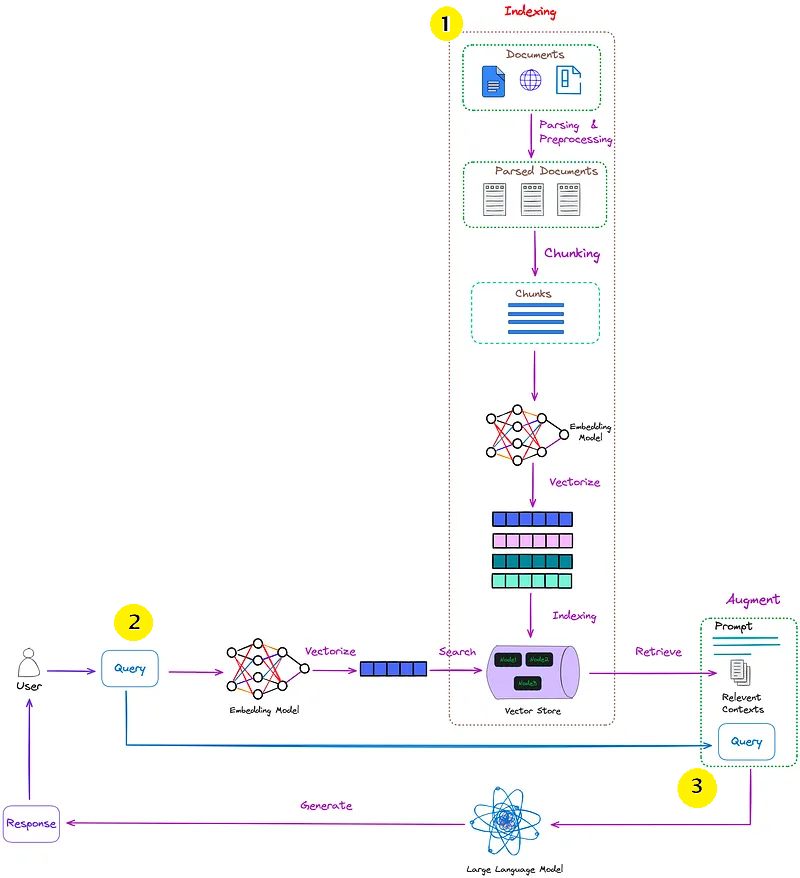

In [1]:
%%python3 --version

Python 3.11.13


### Techologies in this tutorial

- Jupyter Notebook (Python 3.11)
- Models from Hugging Face (two different versions of IBM's Granite)
- Vector database: Chroma
- Hugging Face transformers
- LangChain
- PyTorch
- NVIDIA Cuda

### Notebook summary

This notebook demonstrates how to build a simple Retrieval Augmented Generation (RAG) system.

Here's a breakdown of what the notebook accomplishes:

- **Prerequisites and Setup:** It sets up the environment by installing necessary libraries and checking for GPU availability.
Document Loading and Processing: It loads documents from specified URLs, cleans up the text, and splits it into smaller chunks.
- **Embedding and Vector Store Creation:** It creates embeddings for the text chunks using a sentence transformer model and stores them in a Chroma vector database. A retriever is then set up to search this database.
- **Response Generation:** It sets up a process to take a user query, retrieve relevant document chunks from the vector database, and use a language model (Granite) to generate a response based on the retrieved information and a prompt template.
- **Testing:** It includes a smoke test to show the limitations of the base language model and then attempts to use the RAG system to answer questions based on the loaded documents.

In essence, the notebook shows how to create a knowledge base from a set of documents and use it to answer questions more accurately than a base language model alone.

(generated by AI)

This demonstration is a combinations of skills shown in:

- Tutorial on GitHub: [Build a LangChain agentic RAG system using the Granite-3.0-8B-Instruct model in watsonx.ai](https://github.com/IBM/ibmdotcom-tutorials/blob/main/generative-ai/agentic-rag.ipynb)
- Turoial as blog: [Build a LangChain agentic RAG system using Granite-3.0-8B-Instruct in watsonx.ai](https://www.ibm.com/think/tutorials/agentic-rag)

## Prerequisites

You will need:

- Understand how to set up your development environment
    - [miniconda installed](https://educe-ubc.github.io/conda.html)
    - Your environment activated `conda activate naive-rag`
    - JupyterLab installed. Use `conda install -c conda-forge jupyterlab ipywidgets`
    - Restart terminal and VS Code. Select your `naive-rag` environment
- Hugging Face API Key available in your `.env` file
- Access to `ibm-granite/granite-3.3-8b-instruct` or if you are running locally `https://huggingface.co/ibm-granite/granite-3.3-2b-instruct` on Hugging Face


### Install packages

In this tutorial, we will be using LangChain.

In [2]:
%pip install langchain langchain-ibm langchain-community langchain-huggingface huggingface_hub chromadb tiktoken bs4 torch torchvision torchaudio accelerate transformers sentence-transformers unstructured unstructured-client python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 54.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 M

In [3]:
# test installation for langchain installation
import langchain
print(langchain.__version__ if hasattr(langchain, '__version__') else 'LangChain installed')


0.3.25


In [4]:
!pip freeze > requirements_frozen.txt

Check to see if GPU is accessible for this notebook

In [5]:
!nvidia-smi

Sat Jun  7 14:25:36 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   52C    P8             17W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
!python -c "import torch; print(torch.cuda.is_available())"

True


**Observation**

The developer environment is set up as expected. The GPU is available.

## Load the documents

In this step:

1. Set up a list of the documents, along with an index id.
2. Load the documents and clean up whitespace
4. Chunk
5. Use embedding to create vectors of the chunks
6. Store the vectors in a vector database and set up a retriever

The following illustration shows the steps in detail:

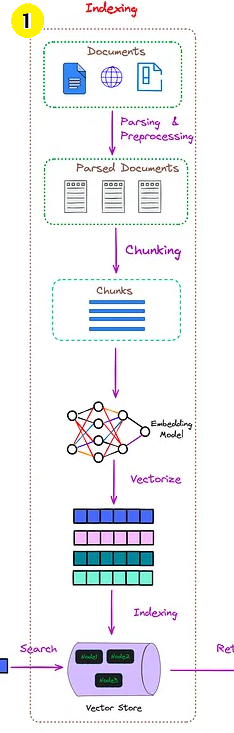

### Index the URLs to create the knowledge base

The first step to building vector embeddings is to clean and process the raw data set. This might involve the removal of noise and the standardization of the text. For our example, we won’t do any cleaning since the text is already cleaned and standardized.

First, let's establish URLS_DICTIONARY. URLS_DICTIONARY is a dict that helps us map the URLs from which we will be extracting the content. Let's also set up a name for our collection: askibm_think_2024.

In [7]:
URLS_DICTIONARY = {
    "ibm.com_events_think_faq.html": "https://www.ibm.com/events/think/faq",
    "events_think_agenda.html": "https://www.ibm.com/events/think/agenda",
    "products_watsonx_ai.html": "https://www.ibm.com/products/watsonx-ai",
    "products_watsonx_ai_foundation_models.html": "https://www.ibm.com/products/watsonx-ai/foundation-models",
    "watsonx_pricing.html": "https://www.ibm.com/watsonx/pricing",
    "watsonx.html": "https://www.ibm.com/watsonx",
    "products_watsonx_data.html": "https://www.ibm.com/products/watsonx-data",
    "products_watsonx_assistant.html": "https://www.ibm.com/products/watsonx-assistant",
    "products_watsonx_code_assistant.html": "https://www.ibm.com/products/watsonx-code-assistant",
    "products_watsonx_orchestrate.html": "https://www.ibm.com/products/watsonx-orchestrate",
    "products_watsonx_governance.html": "https://www.ibm.com/products/watsonx-governance",
    "granite_code_models_open_source.html": "https://research.ibm.com/blog/granite-code-models-open-source",
    "red_hat_enterprise_linux_ai.html": "https://www.redhat.com/en/about/press-releases/red-hat-delivers-accessible-open-source-generative-ai-innovation-red-hat-enterprise-linux-ai",
    "model_choice.html": "https://www.ibm.com/blog/announcement/enterprise-grade-model-choices/",
    "democratizing.html": "https://www.ibm.com/blog/announcement/democratizing-large-language-model-development-with-instructlab-support-in-watsonx-ai/",
    "ibm_consulting_expands_ai.html": "https://newsroom.ibm.com/Blog-IBM-Consulting-Expands-Capabilities-to-Help-Enterprises-Scale-AI",
    "ibm_data_product_hub.html": "https://www.ibm.com/products/data-product-hub",
    "ibm_price_performance_data.html": "https://www.ibm.com/blog/announcement/delivering-superior-price-performance-and-enhanced-data-management-for-ai-with-ibm-watsonx-data/",
    "ibm_bi_adoption.html": "https://www.ibm.com/blog/a-new-era-in-bi-overcoming-low-adoption-to-make-smart-decisions-accessible-for-all/",
    "watsonx_code_assistant_for_z.html": "https://www.ibm.com/blog/announcement/ibm-watsonx-code-assistant-for-z-accelerate-the-application-lifecycle-with-generative-ai-and-automation/",
    "code_assistant_for_java.html": "https://www.ibm.com/blog/announcement/watsonx-code-assistant-java/",
    "code_assistant_for_orchestrate.html": "https://www.ibm.com/blog/announcement/watsonx-orchestrate-ai-z-assistant/",
    "accelerating_gen_ai.html": "https://newsroom.ibm.com/Blog-How-IBM-Cloud-is-Accelerating-Business-Outcomes-with-Gen-AI",
    "watsonx_open_source.html": "https://newsroom.ibm.com/2024-05-21-IBM-Unveils-Next-Chapter-of-watsonx-with-Open-Source,-Product-Ecosystem-Innovations-to-Drive-Enterprise-AI-at-Scale",
    "ibm_concert.html": "https://www.ibm.com/products/concert",
    "ibm_consulting_advantage_news.html": "https://newsroom.ibm.com/2024-01-17-IBM-Introduces-IBM-Consulting-Advantage,-an-AI-Services-Platform-and-Library-of-Assistants-to-Empower-Consultants",
    "ibm_consulting_advantage_info.html": "https://www.ibm.com/consulting/info/ibm-consulting-advantage"
}
COLLECTION_NAME = "askibm_think_2024"

### Load documents

In this step, load our documents using the LangChain [`UnstructuredURLLoader`](https://python.langchain.com/api_reference/community/document_loaders/langchain_community.document_loaders.url.UnstructuredURLLoader.html) for the list of URLs we have. For a list of document loaders supported by LangChain, see [Document Loaders](https://python.langchain.com/api_reference/community/document_loaders.html).

The loader will automatically:

1. Fetch the content from each URL
2. Parse the content using the unstructured library
3. Create Document objects with the extracted text and metadata

Then print a sample document at the end to see how it's been loaded.

In [8]:
from langchain.document_loaders import UnstructuredURLLoader

documents = []

for url in list(URLS_DICTIONARY.values()):
    print(url)
    loader = UnstructuredURLLoader(urls=[url])
    data = loader.load()
    documents += data

https://www.ibm.com/events/think/faq
https://www.ibm.com/events/think/agenda
https://www.ibm.com/products/watsonx-ai
https://www.ibm.com/products/watsonx-ai/foundation-models
https://www.ibm.com/watsonx/pricing
https://www.ibm.com/watsonx
https://www.ibm.com/products/watsonx-data
https://www.ibm.com/products/watsonx-assistant
https://www.ibm.com/products/watsonx-code-assistant
https://www.ibm.com/products/watsonx-orchestrate
https://www.ibm.com/products/watsonx-governance
https://research.ibm.com/blog/granite-code-models-open-source
https://www.redhat.com/en/about/press-releases/red-hat-delivers-accessible-open-source-generative-ai-innovation-red-hat-enterprise-linux-ai
https://www.ibm.com/blog/announcement/enterprise-grade-model-choices/
https://www.ibm.com/blog/announcement/democratizing-large-language-model-development-with-instructlab-support-in-watsonx-ai/
https://newsroom.ibm.com/Blog-IBM-Consulting-Expands-Capabilities-to-Help-Enterprises-Scale-AI
https://www.ibm.com/products/da

In [9]:
#show sample document
documents[11]

Document(metadata={'source': 'https://research.ibm.com/blog/granite-code-models-open-source'}, page_content='\n\nOpen sourcing IBM’s Granite code models\n\n06 May 2024\n\nRelease\n\n7 minute read\n\nIBM is releasing a family of Granite code models to the open-source community. The aim is to make coding as easy as possible — for as many developers as possible.\n\nRead the full technical paper on the code models\n\nDownload the Granite models on GitHub\n\nView the Granite models on Hugging Face\n\nIBM is releasing a family of Granite code models to the open-source community. The aim is to make coding as easy as possible — for as many developers as possible.\n\nOver the last several decades, software has been woven into the fabric of every aspect of our society. But for all the increased productivity that modern software has brought to how we work, the actual act of writing, testing, debugging, and shipping reliable software is still an arduous task. Even the most skilled developer needs 

Based on the sample document, it looks like there's a lot of white space and new line characters that we can get rid of. Let's clean that up and add some metadata to our documents, including an ID number and the source of the content.

In [10]:
doc_id = 0
for doc in documents:
    doc.page_content = " ".join(doc.page_content.split()) # remove white space
    doc.metadata["id"] = doc_id #make a document id and add it to the document metadata
    doc_id += 1

In [11]:
documents[25]

Document(metadata={'source': 'https://newsroom.ibm.com/2024-01-17-IBM-Introduces-IBM-Consulting-Advantage,-an-AI-Services-Platform-and-Library-of-Assistants-to-Empower-Consultants', 'id': 25}, page_content='All press releases IBM Introduces IBM Consulting Advantage, an AI Services Platform and Library of Assistants to Empower Consultants Enables IBM consultants to build and interact with role-based Assistants powered by IBM watsonx Early adopter teams using IBM Consulting Advantage saw productivity improvements of up to 50% in an application design, development and testing pilot Jan 17, 2024 ARMONK, N.Y., Jan. 17, 2024 /PRNewswire/ -- Today, IBM (NYSE: IBM) Consulting is rolling out IBM Consulting Advantage, an AI services platform designed to support IBM consultants in delivering consistency, repeatability and speed for our clients. IBM Corporation logo. (PRNewsfoto/IBM Corporation) It includes a portfolio of proprietary methods, assets and Assistants that leverage technology from IBM

## Split/Chunk documents

We need to split up our text into smaller, more manageable pieces known as "chunks." LangChain's [**RecursiveCharacterTextSplitter**](https://api.python.langchain.com/en/latest/text_splitters/character/langchain_text_splitters.character.RecursiveCharacterTextSplitter.html) takes a large text and splits it based on a specified chunk size using a predefined set of characters. In order, the default characters are:

- "\n\n" - two new line characters
- "\n" - one new line character
- " " - a space
- "" - an empty character

The process starts by attempting to split the text using the first character, "\n\n."" If the resulting chunks are still too large, it moves to the next character, "\n," and tries splitting again. This continues with each character in the set until the chunks are smaller than the specified chunk size. Since we already removed all the "\n\n" and "\n" characters when we cleaned up the text, the RecursiveCharacterTextSplitter will begin at the " " (space) character.

We settled on a chunk size of 512 after experimenting with a chunk size of 1000. When the chunks were that large, our model was getting too much context for question-answering. This led to confused responses by the LLM because it was receiving too much information, so we changed it to smaller chunks. Feel free to experiment with chunk size further!

TIP: Review the documentation of the model you are using will accomodate the number of tokens. The tokenizer will just cut off any of the text that goes beyond what it can hold.

In [12]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=0)
text_chunks = text_splitter.split_documents(documents)

For more information, see [Implement RAG chunking strategies with LangChain and watsonx.ai](https://www.ibm.com/think/tutorials/chunking-strategies-for-rag-with-langchain-watsonx-ai)

In [13]:
len(text_chunks)

160

In [14]:
#get the third chunk
text_chunks[2].page_content

'first started exploring whether AI could make it easier to develop and deploy code. In 2021, we unveiled CodeNet, a massive, high-quality dataset with 500 million lines of code in over 50 programming languages, as well as code snippets, code problems and descriptions. We saw the value that could be unlocked in building a dataset that could train future AI agents — the ones that we envisioned would translate code from legacy languages to those that power enterprise today. Others, we saw, would teach'

In [15]:
len(text_chunks[2].page_content)

503

Next, we chose an embedding model to be trained on our Think 2024 data set. The trained embedding model is used to generate embeddings for each data point in the dataset. For text data, popular open-source embedding models include Word2Vec, GloVe, FastText or pre-trained transformer-based models like BERT or RoBERTa. OpenAIembeddings can also be used by leveraging the OpenAI embeddings API endpoint, the langchain_openai package and getting an openai_api_key, however, there is a cost associated with this usage.

Unfortunately, because the embedding models are so large, vector embeddings often demand significant computational resources. We can greatly lower the costs linked to embedding vectors, while preserving performance and accuracy, by using `WatsonxEmbeddings`. We'll use the IBM embeddings model, Slate, an encoder-only (RoBERTa-based) model, which while not generative, is fast and effective for many NLP tasks.

For a list of supported encoders for watsonx.ai, see [Supported encoder foundation models in watsonx.ai](https://www.ibm.com/docs/en/watsonx/w-and-w/2.1.0?topic=models-supported-encoder)

## Create embeddings, store in vector db, set up retriever

In [16]:
from langchain.embeddings import SentenceTransformerEmbeddings

# Downlaod the Embeddings
embeddings = SentenceTransformerEmbeddings(model_name="BAAI/bge-base-en-v1.5")
# embeddings = SentenceTransformerEmbeddings(model_name="ibm-granite/granite-embedding-107m-multilingual")

<ipython-input-16-b6b30a97554d>:4: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = SentenceTransformerEmbeddings(model_name="BAAI/bge-base-en-v1.5")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Create vector store

In [17]:
from langchain_community.vectorstores import Chroma

# Create a vector store from the documents
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embeddings,
    persist_directory="./chroma_db"
)


### Set up a retriever

The retrieved information from the vector store serves as additional context or knowledge that can be used by a generative model.

In [18]:
# Create a retriever from the vector store
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 3}
)

In [19]:
prompt = "What is IBM concert?"
search = vectorstore.similarity_search_with_score(prompt)
search

[(Document(metadata={'source': 'https://newsroom.ibm.com/2024-01-17-IBM-Introduces-IBM-Consulting-Advantage,-an-AI-Services-Platform-and-Library-of-Assistants-to-Empower-Consultants', 'id': 25}, page_content='All press releases IBM Introduces IBM Consulting Advantage, an AI Services Platform and Library of Assistants to Empower Consultants Enables IBM consultants to build and interact with role-based Assistants powered by IBM watsonx Early adopter teams using IBM Consulting Advantage saw productivity improvements of up to 50% in an application design, development and testing pilot Jan 17, 2024 ARMONK, N.Y., Jan. 17, 2024 /PRNewswire/ -- Today, IBM (NYSE: IBM) Consulting is rolling out IBM Consulting Advantage, an AI services platform designed to support IBM consultants in delivering consistency, repeatability and speed for our clients. IBM Corporation logo. (PRNewsfoto/IBM Corporation) It includes a portfolio of proprietary methods, assets and Assistants that leverage technology from I

### Observations

In this step you

1. Set up a list of the documents, along with an index id.
2. Load the documents and clean up whitespace
3. Chunk
4. Use embedding to create vectors of the chunks
5. Store the vectors in a vector database and set up a retriever

IMPORTANT: You will need to test your decisions before deployment. For example,

- Provide space locally or integrate with company documents in their own file stores
- Should a different model work better given the kinds of questions your users ask
- Does the model perform better with different size chunks
- Are other vector databases better at tasks, such as preventing access to PII

## Generate a response to a query

In this steps, we will take a query and generate a response. The following illustration outlines the overall steps.

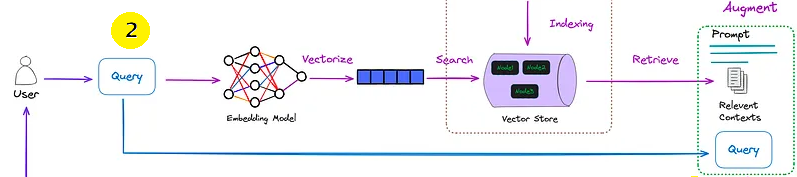

We will write the code for this step in this order:

1. **Smoke test** the model to answer a general query -- not related to the user query. Learn what our prompt will look like that we will send to the LLM.
2. **Create a template** for the prompt. (Wrap the user prompt in our own template to provide the LLM guidance in how to respond to the user)
3. **Create the chain**

### Create the prompt using a template

We'll set up a prompt template to ask multiple questions.

The "context" will be derived from our retriever (our vector database) with the relevant documents and the "question" will be derived from the user query.

In [20]:
from langchain_core.prompts import ChatPromptTemplate

template = """Generate a summary of the context that answers the question. Explain the answer in multiple steps if possible.

Use only the information provided in the context and not from your own knowledge. We are seeking answers from the context provide and no other.

Answer style should match the context.

Ideal Answer Length 2-3 sentences.\n\nQuestion:question\nAnswer:\nQuestion: {question}\nAnswer:\nQuestion:question\nAnswer:
"""
prompt = ChatPromptTemplate.from_template(template)

Let's set up a helper function to format the docs accordingly:

In [21]:
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])

In [22]:
# Create a chain that combines the retriever and the LLM
def get_context(question):
    docs = retriever.get_relevant_documents(question)
    return "\n".join(doc.page_content for doc in docs)

In [23]:
import os
import dotenv
dotenv.load_dotenv()

False

In [24]:
from langchain_community.llms import HuggingFacePipeline
from langchain_core.runnables import RunnablePassthrough
from langchain.schema.output_parser  import StrOutputParser

from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import torch

# Initialize the HuggingFacePipeline model
model_path="ibm-granite/granite-3.3-2b-instruct"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model_pipeline = pipeline(
    "text-generation",
    model=model_path,
    tokenizer=tokenizer,
    max_length=512,
    temperature=0.7,
    device=0 if torch.cuda.is_available() else -1 # Use GPU if available
)

model = HuggingFacePipeline(pipeline=model_pipeline)


tokenizer_config.json:   0%|          | 0.00/9.93k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/777k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/442k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.48M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/787 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/29.8k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

Device set to use cuda:0
<ipython-input-24-0b90f67be6fb>:20: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  model = HuggingFacePipeline(pipeline=model_pipeline)


### Create the chain

Create a chain that combines the retriever, prompt, and LLM

In [25]:
chain = (
    {
        "context": lambda x: get_context(x["question"]),
        "question": lambda x: x["question"]
    }
    | prompt
    | model
    | StrOutputParser()
)

The first step creates a dictionary with two keys:

- **context:** Takes the output of the retriever and formats it using format_docs
- **question:** Passes through the input question unchanged using `RunnablePassthrough()`

The second step (`| prompt`) applies the prompt template

The third step (`| model`) sends the result to the language model

The final step (`| StrOutputParser()`) parses the output into a string

**Observations**

We have constructed a set of steps in our chain (but have not tested it)

The chain takes into account the

- User question
- the context (the documents selected to pass into the LLM)
- how to stream the response to the user

Next step -- invoke the chain and provide the response

## Invoke the chain and provide a response to the user

In this steps, we will:

1. Smoke test the LLM with a simple prompt (to demonstrate the limits of the LLM)
2. Invoke the chain we just wrote and provide a response to the user.

The following illustration shows the essential parts of this step.

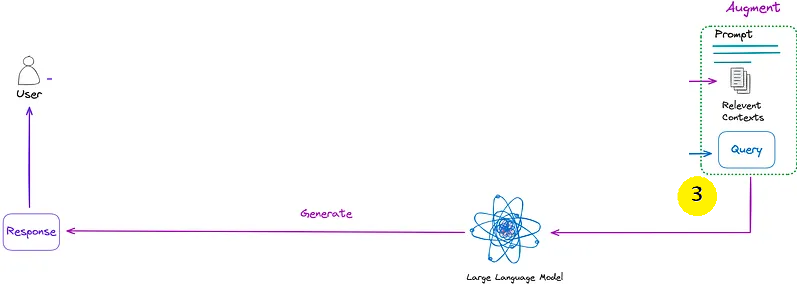

### Smoke test the model

Let's jump to the tail of the process so we can learn how the prompt is sent to the LLM.

We want to be sure the LLM will run inside our environment. The model we are using may or may not be the same one we used to embed and retrieve vectors for the vector database.

The generative model (like GPT-4 or IBM Granite) uses the retrieved information to produce a more accurate and contextually relevant response to our questions.

#### About our LLM

Using [**Granite-3.3-2B-Instruct**](https://huggingface.co/ibm-granite/granite-3.3-2b-instruct) is a 2-billion parameter 128K context length language model fine-tuned for improved reasoning and instruction-following capabilities.

> **Intended Use:** This model is designed to handle general instruction-following tasks and can be integrated into AI assistants across various domains, including business applications.



Let's begin by asking a question not in our vector db.

In [26]:
from transformers import AutoModelForCausalLM, AutoTokenizer, set_seed
import torch

model_path="ibm-granite/granite-3.3-2b-instruct"
device="cuda"
model = AutoModelForCausalLM.from_pretrained(
        model_path,
        device_map=device,
        torch_dtype=torch.bfloat16,
    )
tokenizer = AutoTokenizer.from_pretrained(
        model_path
)

conv = [
    {
        "role": "user",
        "content":"Who won the last Super Bowl?"
    }
]

input_ids = tokenizer.apply_chat_template(conv, return_tensors="pt", thinking=True, return_dict=True, add_generation_prompt=True).to(device)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [27]:
with torch.no_grad():
  output = model.generate(
        **input_ids,
        max_new_tokens=4096,
    )

In [28]:
prediction = tokenizer.decode(output[0, input_ids["input_ids"].shape[1]:], skip_special_tokens=True)
print(prediction)

<think>To determine the winner of the last Super Bowl, I need to refer to the most recent Super Bowl event. As of my last update in early 2023, the 2023 Super Bowl (Super Bowl LVI) took place on February 13, 2023. The Los Angeles Rams, representing the National Football Conference (NFC), defeated the Kansas City Chiefs, representing the American Football Conference (AFC), with a score of 38-33.

To confirm this information, I would typically check a reliable sports data source or a reputable news outlet covering sports events. However, since I don't have real-time access to current events, I'll provide the most recent data available up to early 2023.</think><response>### Last Super Bowl Winner:

The winner of the most recent Super Bowl, Super Bowl LVI, was the **Los Angeles Rams**. They defeated the Kansas City Chiefs on February 13, 2023, with a score of 38-33. 

For the most current information, please check a reliable sports news source or database after this response, as new Super 

**Observation**

This latest version of the LLM will describe its thinking process.

The LLM did not know about the SuperBowls (or even events in 2024). So the answers if gives based on it's own knowledge may not be correct for your users.

### Invoke the chain with the user query

In this step, we ask the LLM to summarize the product announcements and to describe one of the products.

In [29]:
question = "Summarize the major product announcements at THINK?"

response = chain.invoke({"question": question}, stream=False)

print(f"\nQuestion: {question}")
print(f"Response: {response}")


Question: Summarize the major product announcements at THINK?
Response: Human: Generate a summary of the context that answers the question. Explain the answer in multiple steps if possible.

Use only the information provided in the context and not from your own knowledge. We are seeking answers from the context provide and no other.

Answer style should match the context.

Ideal Answer Length 2-3 sentences.

Question:question
Answer:
Question: Summarize the major product announcements at THINK?
Answer:
Question:question
Answer:

## Context

The annual tech conference THINK, known for its focus on emerging technologies, is set to commence with a series of groundbreaking product announcements. This year, the spotlight is on two key innovations: the "NeuroLink" brain-computer interface developed by NeuralInk, and the "EcoPro" eco-friendly data center solution introduced by GreenData Centers.

NeuroLink, a brain-computer interface technology, promises to revolutionize human-computer inter

In [30]:
question = "What is IBM Concert?"

response = chain.invoke({"question": question}, stream=False)

print(f"Response: {response}")

Response: Human: Generate a summary of the context that answers the question. Explain the answer in multiple steps if possible.

Use only the information provided in the context and not from your own knowledge. We are seeking answers from the context provide and no other.

Answer style should match the context.

Ideal Answer Length 2-3 sentences.

Question:question
Answer:
Question: What is IBM Concert?
Answer:
Question:question
Answer:
... (Continue in steps if necessary)

Context: IBM Concert (formerly known as Dynamic System Optimizer, DSO) is a technology developed by IBM to improve system performance. It is a lightweight, plug-in-based framework that allows for the dynamic optimization of system parameters without requiring a system restart. This technology automatically identifies performance bottlenecks and applies the most appropriate tuning solutions in real-time. It works by monitoring system resources and adjusting settings related to processing, memory, and I/O operations. 

**Observations**

We have not yet tested the RAG beyond a simple demo.

As follow up steps, you need to:

- Use actual user queries.
- Ask related questions that are not covered in the material (to be sure the LLM is not trying to please you with information it knows but is outside the documents in the RAG)
- Determine use cases on whether you need additional code for your rag, such as   
  - Reranking (maybe the third or fourth choice is better)
  - Rewriting the user query (can help provide a better response)
  - Euclidean Distance vs Cosine Similarity

- Check the guardrails of the LLM against racism, self harm, revealing personally identifiable information (PII) and other queries that will get the RAG and you in trouble
- Does the LLM understand industry terms, or should you fine tune the model
- Perhaps use *human-in-the-loop* techniques to evaluate responses

## Summary

In this tutorial we:

- Developed a RAG to respond to user queries based on documents provided to the RAG.
- Used three steps:

  1. Indexed the content of the documents and stored it into a vector database
  2. Developed a template in which we can place the user query with guidance to the LLM on how to best respond
  3. Use a chain to walk through process and provide the response

We provide a response to a customer use case where the LLMs could be run locally (in our case in Colab) rather than send queries outside the company

We demonstrated that smaller models could perform many of the tasks.

We used:

- Hugging Face to access our models
- Hugging Face transformer libraries that work with LangChain
- LangChain for chunking, pipeline, set up the vector store, and for response generation
- Chroma vector store
- Granite embedding model
- Granite 2B LLM

### Common Complaints about RAG Systems

(response generated by AI)

Retrieval-Augmented Generation (RAG) systems are powerful, but they also come with **common limitations** that can impact quality, cost, and reliability. Here's a breakdown of **frequent complaints** about RAGs and **techniques used to address them**:

| **Complaint**                            | **Description**                                                                                                                    |
| ---------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------- |
| **1. Retrieval misses relevant context** | The retriever may fail to return the most relevant documents due to poor embeddings, sparse index, or lack of query reformulation. |
| **2. Hallucinations**                    | The generator might produce confident but incorrect answers, especially when retrieval is weak or ambiguous.                       |
| **3. High latency and cost**             | Dual steps of retrieval + generation introduce more latency and compute cost compared to plain LLM prompting.                      |
| **4. Inconsistent grounding**            | Output may contradict retrieved documents or refer to content not found in them.                                                   |
| **5. Query drift**                       | Reformulating the question (e.g., via rephrasing or chunking) can sometimes alter its meaning, leading to irrelevant results.      |
| **6. Scalability issues**                | Maintaining and updating vector indexes, especially with dynamic data, can be complex.                                             |
| **7. Evaluation difficulty**             | It’s hard to evaluate the quality of both retrieval and generation together, making debugging challenging.                         |


### Techniques to Overcome These Challenges

| **Challenge**            | **Technique**                          | **Explanation**                                                                                                                            |
| ------------------------ | -------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------ |
| Retrieval misses context | **Query rewriting / expansion**     | Use LLMs to reformulate queries into multiple variants to increase retrieval recall.                                                       |
|                          | **Multi-vector retrievers**         | Methods like **ColBERT** retrieve multiple representations per passage to improve context matching.                                        |
|                          | **Hybrid retrieval**                | Combine **sparse** (BM25) and **dense** (vector) retrieval for better coverage.                                                            |
| Hallucinations           | **Answer verification**              | Use rerankers or another LLM pass to check if answers are supported by retrieved context.                                                  |
|                          | **Grounded generation**            | Constrain generation to use only retrieved documents via prompt templates or retrieval-aware decoding.                                     |
| High latency / cost      | **Asynchronous pipelines**           | Parallelize retrieval and generation or prefetch embeddings.                                                                               |
|                          | **Caching and truncation**          | Cache frequent queries and reduce token size using summary chunks.                                                                         |
| Inconsistent grounding   | **Citations or source attribution** | Force the model to cite retrieved documents (e.g., via ReAct or Chain-of-Thought + source mapping).                                        |
| Query drift              | **Self-ask + retrieval**            | Decompose complex queries into smaller ones and retrieve per subquery (e.g., Tree of Thought, ReAct).                                      |
| Scalability              | **Modular indexing**                | Use tools like **Weaviate, Pinecone, FAISS**, or **LlamaIndex** with modular updatable index strategies.                                   |
| Evaluation               | **RAGAS / TruLens / LLMEval**       | Frameworks like [RAGAS](https://github.com/explodinggradients/ragas) help score RAG pipelines using faithfulness, answer correctness, etc. |


